In [1]:
from pathlib import Path
from abcnre.simulation import ABCSimulator
from abcnre.simulation.models import create_model_from_dict, get_example_model_configs
import yaml
%load_ext autoreload
%autoreload 2

current_dir = Path().resolve() 
parent_dir = current_dir.parent    
results_dir = parent_dir / "results" 

print("--- Step 1: Load model and create simulator ---")
model_name = "gauss_gauss_2d_default"
model_config = get_example_model_configs(model_name)


model = create_model_from_dict(model_config)
print(f"Model loaded: {model}")


simulator = ABCSimulator(model=model)

INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/antoineluciano/.pyenv/versions/3.10.13/lib/libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/antoineluciano/.pyenv/versions/3.10.13/lib/libtpu.so' (no such file), '/opt/homebrew/lib/libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/lib/libtpu.so' (no such file), '/Users/antoineluciano/.pyenv/versions/3.10.13/lib/libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/antoineluciano/.pyenv/versions/3.10.13/lib/libtpu.so' (no such file), '/opt/homebrew/lib/libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/lib/libtpu.so' (no such file), '/Users

--- Step 1: Load model and create simulator ---
Model loaded: GaussGaussMultiDimModel(dim=2, n_obs=10, marginal_of_interest=0)
📝 Created temporary observed data for prior sampling mode


In [ ]:
print("--- Step 1.5 : Learn Summary Stats (Optional) ---")

import jax
from abcnre.training import get_nn_config
key = jax.random.PRNGKey(123)
key, subkey_learn = jax.random.split(key)


regressor_config = get_nn_config(network_name="deepset",
                          network_size = "default",
                          training_size = "default",
                          task_type = "classifier",
                          lr_scheduler_name = "constant",
                          lr_scheduler_variant = "default",
                          stopping_rules_variant = "balanced",
                          experiment_name = None)
simulator.train_summary_network(subkey_learn)

key, subkey_check = jax.random.split(key)
simulator.check_summary_stats_correlation(
    subkey_check,
    n_samples=10000)

INFO:abcnre.training.config:Using lr_scheduler from training config
INFO:abcnre.training.config:Using stopping rules: balanced
INFO:abcnre.training.config:Created NN config: classifier_deepset_default_default (task: classifier)
INFO:abcnre.training.config:Using stopping rules: balanced
INFO:abcnre.training.config:Created NN config: summary_learner_DeepSet_default_default (task: summary_learner)
INFO:abcnre.training.components.metrics:Configuration Summary:
INFO:abcnre.training.components.metrics:   Task: summary_learner
INFO:abcnre.training.components.metrics:   Network: DeepSet
INFO:abcnre.training.components.metrics:   Optimizer: adam
INFO:abcnre.training.components.metrics:   Learning rate: 0.0003
INFO:abcnre.training.components.metrics:   LR scheduler: cosine
INFO:abcnre.training.components.metrics:   Batch size: 256
INFO:abcnre.training.components.metrics:   Samples/epoch: 10240
INFO:abcnre.training.components.metrics:   Max epochs: 100
INFO:abcnre.training.components.metrics:   S

--- Step 1.5 : Learn Summary Stats (Optional) ---


INFO:abcnre.training.registry:Registered networks: MLP, DeepSet, ConditionedDeepSet
INFO:abcnre.training.registry:Set output_dim=1 for DeepSet network
INFO:abcnre.training.registry:Created DeepSet network (from 'DeepSet') for summary_learner
INFO:abcnre.training.registry:Network args: {'activation': 'relu', 'use_layer_norm': True, 'dropout_rate': 0.0, 'pooling_type': 'mean', 'phi_hidden_dims': [32, 16], 'rho_hidden_dims': [32, 16], 'output_dim': 1}
INFO:abcnre.training.components.setup:Created network: DeepSet
INFO:abcnre.training.components.setup:Network initialized with 1,905 parameters
INFO:abcnre.training.components.setup:Using same generator for validation data
INFO:abcnre.training.components.setup:Setup complete. Initial simulations: 1034
INFO:abcnre.training.components.metrics:============================================================
INFO:abcnre.training.components.metrics:Starting summary_learner training
INFO:abcnre.training.components.metrics:Epochs: 100, Batch size: 256, 

✅ Updating model's summary statistics function...
📝 Created temporary observed data for prior sampling mode
✅ Summary statistics learned and updated successfully!
   - Original data dimension: (10, 2)
   - Learned summary function integrated into model
Shapes : phi_samples: (10000, 1) x_samples: (10000, 10, 2)
Shapes: summary_stats: (10000, 1) phi_samples: (10000, 1)
Correlation between summary statistics and model parameters: [[0.99152344]]


Array([[0.99152344]], dtype=float32)

In [3]:
print("--- Step 2.1: Sample x_obs and initialize the ABCSimulator ---")

model = simulator.model

key, key_prior = jax.random.split(key)
true_theta = model.get_prior_sample(key_prior)

true_phi = 5.
true_theta = true_theta.at[model.marginal_of_interest].set(true_phi)

key, subkey_sample = jax.random.split(key)
x_obs = model.simulate_data(subkey_sample, true_theta)

simulator.update_observed_data(x_obs)
print(f"Observation x_obs: {x_obs}")

quantile_distance = 1.
key, subkey_epsilon = jax.random.split(key)
simulator.set_epsilon_from_quantile(key = subkey_epsilon, quantile_distance=quantile_distance, n_samples=10000)

--- Step 2.1: Sample x_obs and initialize the ABCSimulator ---
🔄 Updated sampler with new observed data.
Observation x_obs: [[3.8779953 5.4392505]
 [4.2484436 2.6905732]
 [6.245473  5.323924 ]
 [4.0488725 2.7398715]
 [4.434888  5.2062173]
 [3.1106958 3.183335 ]
 [6.702392  3.8085222]
 [6.885131  4.337118 ]
 [5.61605   2.8866549]
 [4.71031   5.3226976]]


In [4]:
print("--- Step 2.2: Save model to YAML (Optional) ---")

from abcnre.simulation import save_simulator_to_yaml


save_simulator_to_yaml(
    simulator,
    results_dir / "simulator" / "simulator.yaml",
    overwrite=True
)

INFO:abcnre.simulation.models.io:Model saved to: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_2D/results/simulator/simulator_model.yml
INFO:abcnre.simulation.io:Saved model configuration to: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_2D/results/simulator/simulator_model.yml
INFO:abcnre.simulation.io:Saved observed data to: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_2D/results/simulator/simulator_observed_data.npy
INFO:abcnre.training.config:Configuration saved to /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_2D/results/simulator/simulator_summary_network_config.yml
INFO:abcnre.simulation.io:Saved summary network weights to: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_2D/results/simulator/simulator_summary_network_weights.npz
INFO:abcnre.simulation.io:ABCSimulator configuration saved to: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/a

--- Step 2.2: Save model to YAML (Optional) ---


--- Step 2.3 : Load model from YAML and check (Optional) ---

INFO:abcnre.simulation.io:Loaded model: GaussGaussMultiDimModel
INFO:abcnre.simulation.io:Loaded observed data from: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_2D/results/simulator/simulator_observed_data.npy
INFO:abcnre.training.config:Loaded configuration from /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_2D/results/simulator/simulator_summary_network_config.yml
INFO:abcnre.simulation.io:Loaded summary network config from: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_2D/results/simulator/simulator_summary_network_config.yml
INFO:abcnre.simulation.io:Loaded summary network weights from: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_2D/results/simulator/simulator_summary_network_weights.npz
INFO:abcnre.training.registry:Registered networks: MLP, DeepSet, ConditionedDeepSet
INFO:abcnre.training.registry:Set output_dim=1 for DeepSet network
INFO:abcnre.training.registry:Cre


Computing epsilon for 100.0% quantile...
Setting epsilon to infinity (maximum distance).


INFO:abcnre.simulation.io:Summary network loaded and integrated into simulator


Text(0.5, 0, 'Phi samples')

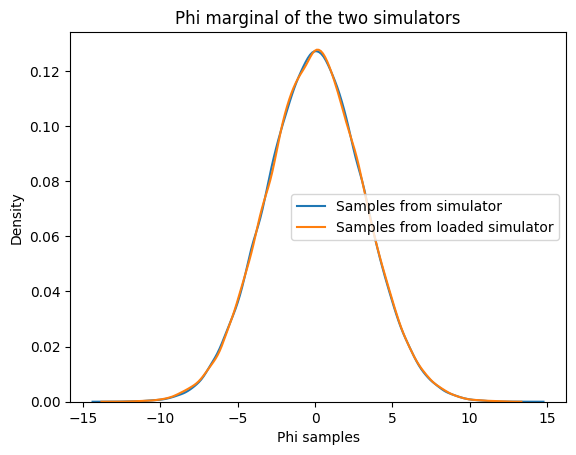

In [5]:
print("--- Step 2.3 : Load model from YAML and check (Optional) ---")

from abcnre.simulation import load_simulator_from_yaml
simulator_loaded = load_simulator_from_yaml(
    results_dir / "simulator" / "simulator.yaml",
)

key, key_samples, key_samples_load = jax.random.split(key, 3)
samples = simulator_loaded.generate_samples(key_samples, n_samples=100000)
samples_load = simulator_loaded.generate_samples(key_samples_load, n_samples=100000)

import seaborn as sns
import matplotlib.pyplot as plt
sns.kdeplot(samples.phi.flatten(), label="Samples from simulator"
            )
sns.kdeplot(samples_load.phi.flatten(), label="Samples from loaded simulator")
plt.legend()
plt.title("Phi marginal of the two simulators")
plt.xlabel("Phi samples")

In [6]:
from abcnre.training import NNConfig, NetworkConfig, TrainingConfig, get_nn_config
print("--- Step 3.1: Create NNConfig for training ---")
nn_config = get_nn_config(network_name="mlp",
                          network_size = "default",
                          training_size = "default",
                          task_type = "classifier",
                          lr_scheduler_name = "reduce_on_plateau",
                          lr_scheduler_variant = "default",
                          stopping_rules_variant = "balanced",
                          experiment_name = None)


nn_config.training.num_epochs = 500
nn_config.training.batch_size = 1024
nn_config.training.n_samples_per_epoch = 10240
nn_config.training.learning_rate = 1e-2
nn_config.training.optimizer= "adamw"
nn_config.training.weight_decay = 1e-3

INFO:abcnre.training.config:Using custom lr_scheduler: reduce_on_plateau_default
INFO:abcnre.training.config:Using stopping rules: balanced
INFO:abcnre.training.config:Created NN config: classifier_mlp_default_default (task: classifier)


--- Step 3.1: Create NNConfig for training ---


In [7]:
print("--- Step 3.2: Create NeuralRatioEstimator ---")

from abcnre.inference import NeuralRatioEstimator    

estimator = NeuralRatioEstimator(
    nn_config=nn_config,
    simulator=simulator)

--- Step 3.2: Create NeuralRatioEstimator ---


In [8]:
print("--- Step 3.3: Train the NeuralRatioEstimator ---")

key, key_train = jax.random.split(key)
res = estimator.train(key_train, n_phi_to_store = 10000)

INFO:abcnre.inference.estimator:Using MLP without summary statistics
INFO:abcnre.inference.estimator:Storing 10000 phi during training
INFO:abcnre.training.components.metrics:Configuration Summary:
INFO:abcnre.training.components.metrics:   Task: classifier
INFO:abcnre.training.components.metrics:   Network: MLP
INFO:abcnre.training.components.metrics:   Optimizer: adamw
INFO:abcnre.training.components.metrics:   Learning rate: 0.01
INFO:abcnre.training.components.metrics:   LR scheduler: reduce_on_plateau
INFO:abcnre.training.components.metrics:   Batch size: 1024
INFO:abcnre.training.components.metrics:   Samples/epoch: 10240
INFO:abcnre.training.components.metrics:   Max epochs: 500
INFO:abcnre.training.components.metrics:   Stopping rules: Enabled
INFO:abcnre.training.components.metrics:   Phi storage: 10000 values
INFO:abcnre.training.components.setup:Setting up classifier training
INFO:abcnre.training.components.setup:Epochs: 500, Batch size: 1024, Batches/epoch: 10


--- Step 3.3: Train the NeuralRatioEstimator ---


INFO:abcnre.training.registry:Registered networks: MLP, DeepSet, ConditionedDeepSet
INFO:abcnre.training.registry:Set output_dim=1 for MLP network
INFO:abcnre.training.registry:Created MLP network (from 'MLP') for classifier
INFO:abcnre.training.registry:Network args: {'activation': 'relu', 'use_layer_norm': False, 'dropout_rate': 0.0, 'hidden_dims': [64, 64, 64], 'output_dim': 1}
INFO:abcnre.training.components.setup:Created network: MLP
INFO:abcnre.training.components.setup:Network initialized with 9,793 parameters
INFO:abcnre.training.components.setup:Using same generator for validation data
INFO:abcnre.training.components.setup:Setup complete. Initial simulations: 517
INFO:abcnre.training.components.schedulers:Initialized reduce-on-plateau scheduler
INFO:abcnre.training.components.loop:Initialized phi storage for 10000 values
INFO:abcnre.training.components.metrics:============================================================
INFO:abcnre.training.components.metrics:Starting classifi

✅ Neural Ratio Estimator training completed successfully!
   - Final train loss: 0.2073436826467514
   - Total simulations: 307717


In [9]:
print("--- Step 3.4: Save the NeuralRatioEstimator to YAML (Optional) ---")

from abcnre.inference.io import save_estimator_to_yaml
save_estimator_to_yaml(
    estimator,
    results_dir / "estimator" / "estimator.yaml",
    overwrite=True
)


INFO:abcnre.training.config:Configuration saved to /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_2D/results/estimator/estimator_classif_config.yaml
INFO:abcnre.inference.io:Saved classifier config to: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_2D/results/estimator/estimator_classif_config.yaml
INFO:abcnre.simulation.models.io:Model saved to: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_2D/results/estimator/estimator_simulator_model.yml
INFO:abcnre.simulation.io:Saved model configuration to: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_2D/results/estimator/estimator_simulator_model.yml
INFO:abcnre.simulation.io:Saved observed data to: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_2D/results/estimator/estimator_simulator_observed_data.npy
INFO:abcnre.training.config:Configuration saved to /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnr

--- Step 3.4: Save the NeuralRatioEstimator to YAML (Optional) ---
True stored_phis attribute not found in estimator


INFO:abcnre.training.config:Loaded configuration from /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_2D/results/estimator/estimator_classif_config.yaml
INFO:abcnre.simulation.io:Loaded model: GaussGaussMultiDimModel
INFO:abcnre.simulation.io:Loaded observed data from: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_2D/results/estimator/estimator_simulator_observed_data.npy
INFO:abcnre.training.config:Loaded configuration from /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_2D/results/estimator/estimator_simulator_summary_network_config.yml
INFO:abcnre.simulation.io:Loaded summary network config from: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_2D/results/estimator/estimator_simulator_summary_network_config.yml
INFO:abcnre.simulation.io:Loaded summary network weights from: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_2D/results/estimator/estimator_sim

--- Step 3.5: Load the NeuralRatioEstimator from YAML and check (Optional) ---
Computing epsilon for 100.0% quantile...
Setting epsilon to infinity (maximum distance).


Text(0.5, 1.0, 'Phi marginal of the two estimators')

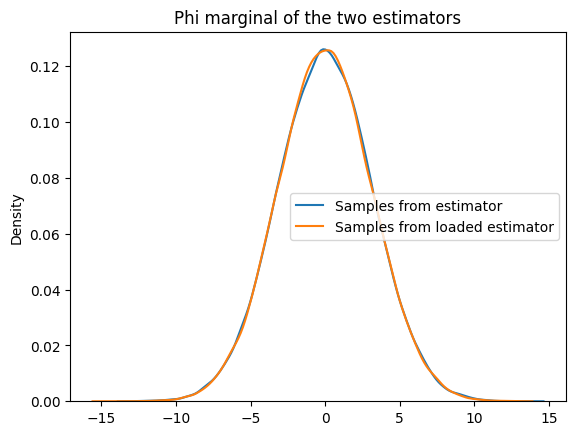

In [10]:
print("--- Step 3.5: Load the NeuralRatioEstimator from YAML and check (Optional) ---")

from abcnre.inference import load_estimator_from_yaml

estimator_loaded = load_estimator_from_yaml(
    results_dir / "estimator" / "estimator.yaml",
)

key, key_samples_estimator, key_samples_estimator_load = jax.random.split(key, 3)
samples_estimator = estimator.simulator.generate_samples(key_samples_estimator, n_samples=100000)
samples_estimator_load = estimator_loaded.simulator.generate_samples(key_samples_estimator_load, n_samples=100000)
import seaborn as sns
import matplotlib.pyplot as plt
sns.kdeplot(samples_estimator.phi.flatten(), label="Samples from estimator")
sns.kdeplot(samples_estimator_load.phi.flatten(), label="Samples from loaded estimator")
plt.legend()
plt.title("Phi marginal of the two estimators") 

In [1]:
from abcnre.diagnostics.posterior import get_unnormalized_nre_pdf, get_normalized_pdf, get_unnormalized_corrected_nre_pdf
from abcnre.diagnostics.viz import plot_posterior_comparison
import numpy as np

abc_phi_samples = estimator.stored_phis
min_phi, max_phi = np.min(abc_phi_samples), np.max(abc_phi_samples)

n_grid = 10000  # Number of grid points for the posterior distribution
abc_phi_grid = np.linspace(min_phi, max_phi, n_grid)

# Get posterior distributions
unnormalized_pdf_func = get_unnormalized_nre_pdf(estimator)
phi_grid, nre_pdf = get_normalized_pdf(unnormalized_pdf_func, 
                                       initial_bounds=(min_phi, max_phi), 
                                        n_grid_points=n_grid)

# Get prior for plotting
prior_pdf_values = simulator.model.prior_phi_pdf(abc_phi_grid)

true_grid, true_pdf = get_normalized_pdf(simulator.model.get_posterior_phi_distribution(simulator.observed_data).pdf, initial_bounds=(min_phi, max_phi))

unnormalized_corrected_pdf_func = get_unnormalized_corrected_nre_pdf(estimator)

phi_corrected_grid, unnormalized_corrected_pdf = get_normalized_pdf(
                                    unnormalized_pdf_func=unnormalized_corrected_pdf_func,
                                    initial_bounds=(min_phi, max_phi),
                                    n_grid_points=n_grid
)

phi_corrected_grid, unnormalized_corrected_pdf = get_normalized_pdf(
    unnormalized_pdf_func=unnormalized_corrected_pdf_func,
    initial_bounds=(min_phi, max_phi),
    n_grid_points=n_grid
)

# Generate the comparison plot - flatten ABC samples to 1D
plot_posterior_comparison(
    distributions={
        'NRE Posterior': (phi_grid, nre_pdf), 
        'ABC Posterior': abc_phi_samples.flatten(),  # Flatten to 1D array
        'True Posterior': (true_grid, true_pdf), 
        'Corrected NRE Posterior': (phi_corrected_grid, unnormalized_corrected_pdf)
    },
    prior_pdf=(abc_phi_grid, prior_pdf_values),
    xlim=(3,7)
    # save_path=output_dir / "posterior_comparison.png"
)

print("\n✅ Diagnostics complete.")

NameError: name 'estimator' is not defined